In [1]:
# This performs a CWT of each beat. As this is going to be a CWT of more widths, there needs to be extra padding
# on the sides of each CWT that is then cut off to get rid of boundary effects from the CWT

In [3]:
# import packages
from scipy import signal
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pywt
import PIL
from PIL import Image
from skimage.transform import resize
import math
from pywt._doc_utils import boundary_mode_subplot


In [4]:
##### This is the function that performs the CWT of the beat 

def CWT(beat ,widths=np.arange(1,128)):
    # This performs a CWT of every channel of the segment, then adds and axis and stacks them
    # First find the number of channels in the segment
    num_leads = beat.shape[-1] 
    pad = 350
    # Before performing the CWT, the sides of the array need to be padded:
    padded_1 = np.pad(beat[:,0],(pad,pad),'edge')
    padded_2 = np.pad(beat[:,1],(pad,pad),'edge')
    beat = np.stack((padded_1,padded_2),axis=-1)
    
    # Now loop over every channel and perform the CWT:
    for i in range(num_leads):
        if i == 0:
            cwtmatr, freqs = pywt.cwt(beat[:,i], widths, 'cmor1.5-1')
            cwtha = abs(cwtmatr)
            
            # Need to cut off the ends of the CWT that were added to counter the edge effects
            cwtha = cwtha[:,pad:-pad]
            # Need to resize it to the correct shape
            resized1 = resize(cwtha, (128,128))
            
            # Normalise all the values 
            mean = np.mean(resized1)
            resized1 -= mean
            std = np.std(resized1)
            resized1 /= std
            
            resized1 = np.array(resized1, dtype=np.float32)
            sample = resized1[:,:,np.newaxis]
        else:
            cwtmatr, freqs = pywt.cwt(beat[:,i], widths, 'cmor1.5-1')
            cwtha = abs(cwtmatr)
            cwtha = cwtha[:,pad:-pad]
            resized1 = resize(cwtha, (128,128))
            
            # Normalise all the values 
            mean = np.mean(resized1)
            resized1 -= mean
            std = np.std(resized1)
            resized1 /= std

            resized1 = np.array(resized1, dtype=np.float32)
            resized1 = resized1[:,:,np.newaxis]
            sample = np.concatenate((sample,resized1),axis=-1)
        
    return sample

(830, 2)
(128, 128, 2)
[1. 0.]


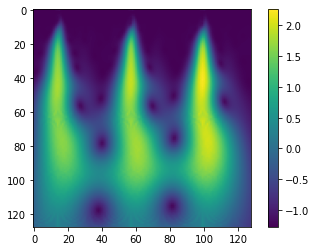

In [224]:
# test CWT on single segment
segment_num = 8460
with open('3 Beat Train Data/seg_{}.pkl'.format(segment_num), 'rb') as f:
    segment = pkl.load(f)
print(np.shape(segment))
CWTed = CWT(segment)
print(np.shape(CWTed))
plt.imshow(CWTed[:,:,0])
plt.colorbar()
plt.savefig('CWT of 3beatnormalpreCWT.pdf')
with open('Test CWT 3beat.pkl','wb') as f:
    pkl.dump(CWTed,f)
with open('CNN_3_Beat_binary_label_OHE.pkl', 'rb') as f:
    labels = pkl.load(f)
print(labels[segment_num])

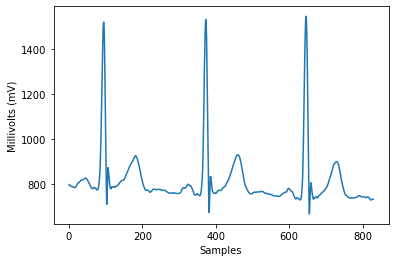

In [225]:
plt.plot(segment[:,0])
plt.xlabel('Samples')
plt.ylabel('Millivolts (mV)')
plt.savefig('3beatnormalpreCWT.pdf')
plt.show()

In [201]:
np.save('test', CWTed, allow_pickle = True)

In [101]:
# This is a loop to perform a CWT of every sample
num_of_samples = 8260
full_labels = []
train_labels = []
test_labels = []
train_count = 0
test_count = 0
# Load in segment labels
with open('CNN_3_Beat_label_OHE.pkl', 'rb') as f:
    full_labels = pkl.load(f)
    
# Cycle through each sample, perform CWT, and save to either train or test folder
# 1000 of each category are saved to train set, 180 of each saved to test set
for i in range(num_of_samples):
    with open('3 Beat Train Data/seg_{}.pkl'.format(i), 'rb') as f:
        segment = pkl.load(f)
    CWTed = CWT(segment)
    if (i%1180 < 1000):
        np.save('3 Beat CWT Train/sample_{}'.format(train_count),CWTed ,allow_pickle = True)
        train_count += 1
        train_labels.append(full_labels[i])
    else:
        np.save('3 Beat CWT Test/sample_{}'.format(test_count),CWTed ,allow_pickle = True)
        test_count += 1
        test_labels.append(full_labels[i])
    if i%100 == 0:
        print(i)
print('done')
print(train_count, test_count)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
done
7000 1260


In [102]:
# save labels
with open('CNN_3_Beat_Test_Labels_OHE.pkl', 'wb') as f:
    pkl.dump(test_labels, f)
with open('CNN_3_Beat_Train_Labels_OHE.pkl', 'wb') as f:
    pkl.dump(train_labels, f)